In [56]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score



In [44]:
# Load the dataset
df = pd.read_csv("air_pollution_data.csv")

# Preprocessing
# Assuming 'dt' is the timestamp column
df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)

# Define the sequence length
sequence_length = 10

# Create overlapping sequences and corresponding target sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])  # Target is the next element after the sequence
    return np.array(X), np.array(y)

# Create input sequences and corresponding target sequences
X, y = create_sequences(df.values, sequence_length)

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, sequence_length * X.shape[2])).reshape(X.shape)
y_scaled = scaler.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)




In [63]:
# Build the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=50, activation='relu', return_sequences=True),  # Add another LSTM layer
    LSTM(units=50, activation='relu'),  # Add another LSTM layer
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')#, metrics=['mae', 'mse', 'mape'])

# Train the model
history=model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)




Epoch 1/50


c:\Users\nikit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1985 - val_loss: 0.1279
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1298 - val_loss: 0.1254
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1296 - val_loss: 0.1253
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1299 - val_loss: 0.1251
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1278 - val_loss: 0.1257
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1284 - val_loss: 0.1248
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1275 - val_loss: 0.1244
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1275 - val_loss: 0.1244
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1270 - val_loss: 0.1248
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1269 - val_loss: 0.1239
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1256 - val_loss: 0.1233
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1262 - val_loss: 0.1233

In [64]:
# Prepare the input data for prediction
# Assuming you want to predict the next  AQI value
num_predictions = 1
input_data = X_test[-1]  # Use the last sequence from the test set as input


# Verify the shape of input_data
print("Shape of input data before reshaping:", input_data.shape)

# Reshape the input data to match the model's input shape
reshaped_input_data = input_data.reshape(1, sequence_length, X.shape[2])
print("Shape of input data after reshaping:", reshaped_input_data.shape)



# Make predictions
predicted_values = []
for _ in range(num_predictions):
    # Predict the next AQI value
    next_prediction = model.predict(reshaped_input_data)[0][0]
    # Store the predicted value
    predicted_values.append(next_prediction)
    # Update the input data for the next prediction
    input_data = np.append(input_data[1:], next_prediction)

# Print the predicted AQI values
print("Predicted AQI values:")
for i, value in enumerate(predicted_values, 1):
    print(f"Prediction {i}: {value*10:.0f}")  #of to remove decimal point


Shape of input data before reshaping: (10, 9)
Shape of input data after reshaping: (1, 10, 9)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Predicted AQI values:
Prediction 1: 2


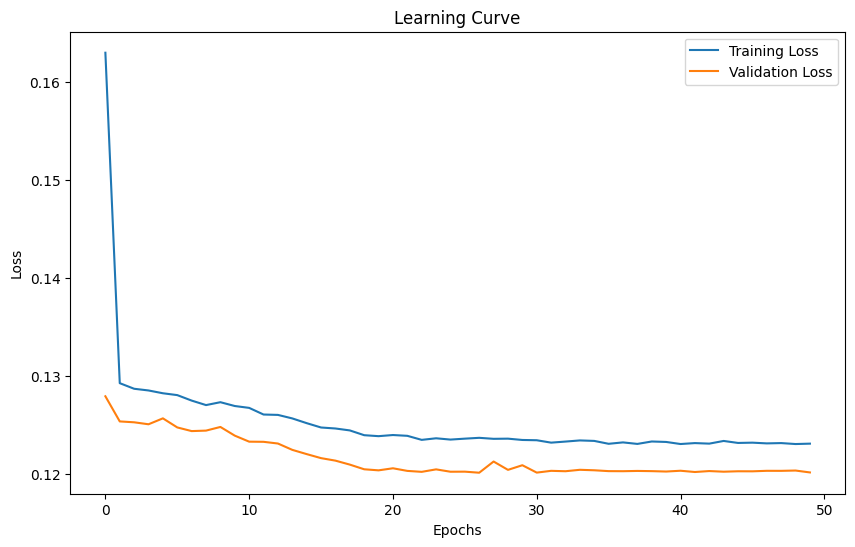

In [65]:
import matplotlib.pyplot as plt

# Get training and validation loss from the model's history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()